   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11

2025-12-11 07:26:15.510818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765437975.768840      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765437975.846890      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


特徵工程處理中...


2025-12-11 07:27:02.929489: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - AUC: 0.5028 - accuracy: 0.5042 - loss: 1.5739 - val_AUC: 0.5022 - val_accuracy: 0.5017 - val_loss: 1.2825
Epoch 2/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - AUC: 0.5121 - accuracy: 0.5102 - loss: 1.2595 - val_AUC: 0.7020 - val_accuracy: 0.6566 - val_loss: 1.0956
Epoch 3/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 0.7455 - accuracy: 0.6884 - loss: 1.0301 - val_AUC: 0.8467 - val_accuracy: 0.7718 - val_loss: 0.8755
Epoch 4/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 0.8392 - accuracy: 0.7658 - loss: 0.8731 - val_AUC: 0.8515 - val_accuracy: 0.7734 - val_loss: 0.8169
Epoch 5/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - AUC: 0.8438 - accuracy: 0.7674 - loss: 0.8159 - val_AUC: 0.8525 - val_accuracy: 0.7735 - val_loss: 0.7727
Epoch 6/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 0.8469 - accuracy: 0.7695 - loss: 0.7699 - val_AUC: 0.8538 - val_accuracy: 0.7730 - val_loss: 0.7358
Epoch 7/40
528/528 ━━━━━━━━━

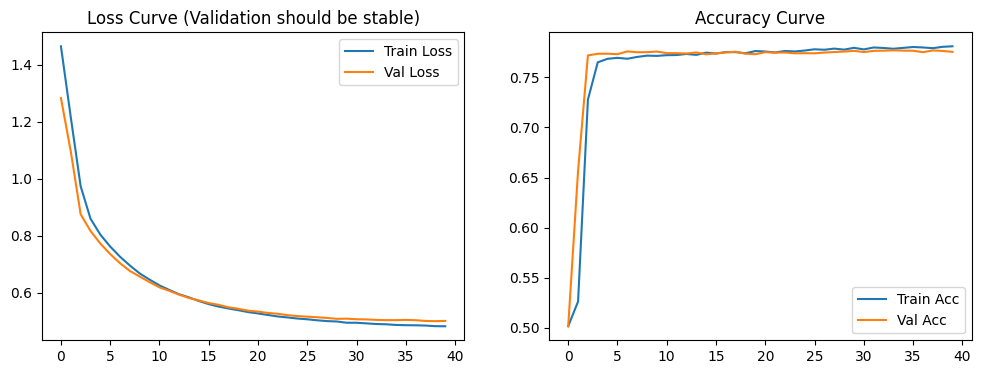

In [1]:
# =========================================================
# MM-DNN Final Fix: Heavy Regularization (解決 val_loss 上升問題)
# Goal: Stop Overfitting & Maximize Generalization
# =========================================================

!pip install protobuf==3.20.3 rdkit-pypi -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import tensorflow as tf

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras import layers, models, callbacks, regularizers

# 1. 讀取資料
paths = ["/kaggle/input/drug-repositioning/", "./"]
drugs = None
for path in paths:
    try:
        drugs = pd.read_csv(f"{path}drugsInfo.csv")
        diseases = pd.read_csv(f"{path}diseasesInfo.csv")
        mapping = pd.read_csv(f"{path}mapping.csv")
        break
    except FileNotFoundError:
        continue

if drugs is None: raise FileNotFoundError("找不到資料！")

# =========================================================
# 2. 特徵工程
# =========================================================
print("特徵工程處理中...")

# Drug Fingerprints
def smiles_to_fp(smile, n_bits=1024):
    try:
        mol = Chem.MolFromSmiles(str(smile))
        if mol is None: return np.zeros(n_bits, dtype=np.int8)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.int8)
        Chem.DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    except:
        return np.zeros(n_bits, dtype=np.int8)

fp_matrix = np.stack(drugs["DrugSmile"].apply(smiles_to_fp).values)

# Targets & Categories
drugs['Target_List'] = drugs['DrugTarget'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
mlb_target = MultiLabelBinarizer()
target_matrix = mlb_target.fit_transform(drugs['Target_List'])

drugs['Cat_List'] = drugs['DrugCategories'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
mlb_cat = MultiLabelBinarizer()
cat_matrix = mlb_cat.fit_transform(drugs['Cat_List'])

drug_features = np.concatenate([fp_matrix, target_matrix, cat_matrix], axis=1)
drug_dim = drug_features.shape[1]

drug_feat_df = pd.DataFrame(drug_features, columns=[f"F_{i}" for i in range(drug_dim)])
drug_feat_df["DrugID"] = drugs["DrugID"]

# Disease Features
le_disease = LabelEncoder()
diseases["freq_id"] = le_disease.fit_transform(diseases["DiseaseID"])
num_diseases = len(le_disease.classes_)

diseases['PathwayNames'] = diseases['PathwayNames'].fillna('Unknown')
le_pathway = LabelEncoder()
diseases['path_id'] = le_pathway.fit_transform(diseases['PathwayNames'].astype(str))
num_pathways = len(le_pathway.classes_)

disease_map = diseases[["DiseaseID", "freq_id", "path_id"]]

# =========================================================
# 3. 建立資料集
# =========================================================
pos_data = mapping.merge(drug_feat_df, on="DrugID", how="left").merge(disease_map, on="DiseaseID", how="left")
pos_data["label"] = 1

all_disease_ids = diseases["DiseaseID"].values
drug_to_diseases = mapping.groupby("DrugID")["DiseaseID"].apply(set).to_dict()
neg_list = []
rng = np.random.default_rng(42)

for drug_id, pos_set in drug_to_diseases.items():
    candidates = np.setdiff1d(all_disease_ids, list(pos_set))
    n_neg = min(len(pos_set), len(candidates))
    if n_neg > 0:
        sampled = rng.choice(candidates, size=n_neg, replace=False)
        for d_id in sampled:
            neg_list.append((drug_id, d_id))

neg_df = pd.DataFrame(neg_list, columns=["DrugID", "DiseaseID"])
neg_data = neg_df.merge(drug_feat_df, on="DrugID", how="left").merge(disease_map, on="DiseaseID", how="left")
neg_data["label"] = 0

full_data = pd.concat([pos_data, neg_data], ignore_index=True)
full_data = full_data.sample(frac=1.0, random_state=42).reset_index(drop=True)
full_data.dropna(inplace=True)

# Split
feature_cols = [f"F_{i}" for i in range(drug_dim)]
X_drug = full_data[feature_cols].values.astype(np.float32)
X_did = full_data["freq_id"].values.astype(np.int32)
X_path = full_data["path_id"].values.astype(np.int32)
y = full_data["label"].values.astype(np.float32)

X_drug_tr, X_drug_te, X_did_tr, X_did_te, X_path_tr, X_path_te, y_tr, y_te = train_test_split(
    X_drug, X_did, X_path, y, test_size=0.2, random_state=42, stratify=y
)

# =========================================================
# 4. 模型：NeuMF Style (Heavy Regularization)
# =========================================================
def build_regularized_model(drug_dim, num_diseases, num_pathways, latent_dim=64):
    
    # --- A. Drug Tower ---
    input_drug = layers.Input(shape=(drug_dim,), name="Drug_In")
    # L2 加強 (0.001) + Dropout 加強 (0.5)
    x_drug = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001))(input_drug)
    x_drug = layers.BatchNormalization()(x_drug)
    x_drug = layers.Activation('relu')(x_drug)
    x_drug = layers.Dropout(0.5)(x_drug) 
    
    vec_drug = layers.Dense(latent_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x_drug)

    # --- B. Disease Tower ---
    input_did = layers.Input(shape=(1,), name="Disease_ID")
    input_path = layers.Input(shape=(1,), name="Pathway_ID")
    
    emb_did = layers.Embedding(num_diseases, latent_dim)(input_did)
    emb_did = layers.Flatten()(emb_did)
    
    emb_path = layers.Embedding(num_pathways, latent_dim)(input_path)
    emb_path = layers.Flatten()(emb_path)
    
    x_dis = layers.Concatenate()([emb_did, emb_path])
    x_dis = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x_dis)
    x_dis = layers.Dropout(0.3)(x_dis) # 疾病特徵較少，Dropout 不用那麼重
    
    vec_disease = layers.Dense(latent_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x_dis)

    # --- C. Interaction ---
    multiply = layers.Multiply()([vec_drug, vec_disease])
    concat = layers.Concatenate()([vec_drug, vec_disease])
    x = layers.Concatenate()([multiply, concat])
    
    # --- D. Final Classification ---
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x) # 輸出層前再加強 Dropout
    
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    
    return models.Model(inputs=[input_drug, input_did, input_path], outputs=output)

model = build_regularized_model(drug_dim, num_diseases, num_pathways)

# Learning Rate 降到 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss="binary_crossentropy", metrics=["accuracy", "AUC"])

# =========================================================
# 5. 訓練 (改監控 val_loss)
# =========================================================
# 關鍵修改：monitor='val_loss', mode='min'
# 一旦 loss 開始上升，耐心等 5 次，如果沒降回來就立刻停止並還原
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min', 
    restore_best_weights=True
)

history = model.fit(
    [X_drug_tr, X_did_tr, X_path_tr], y_tr,
    validation_data=([X_drug_te, X_did_te, X_path_te], y_te),
    epochs=40, # 給多一點 epoch 讓它慢跑，反正有 early stop
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# =========================================================
# 6. 尋找最佳門檻值
# =========================================================
y_pred_prob = model.predict([X_drug_te, X_did_te, X_path_te]).ravel()

best_acc = 0
best_thresh = 0.5
best_f1 = 0

thresholds = np.arange(0.3, 0.71, 0.01)
print("\n正在搜尋最佳 Accuracy 門檻值...")

for thresh in thresholds:
    y_pred_temp = (y_pred_prob > thresh).astype(int)
    acc = accuracy_score(y_te, y_pred_temp)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh
        best_f1 = f1_score(y_te, y_pred_temp)

print("-" * 30)
print(f"🏆 最終優化結果 (Heavy Regularization) 🏆")
print(f"最佳門檻值: {best_thresh:.2f}")
print(f"Accuracy : {best_acc:.4f}")
print(f"F1 Score : {best_f1:.4f}")
print(f"AUC      : {roc_auc_score(y_te, y_pred_prob):.4f}")
print("-" * 30)

# 繪圖檢查
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve (Validation should be stable)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

正在繪製訓練過程圖表...
訓練紀錄包含的 Keys: ['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss']


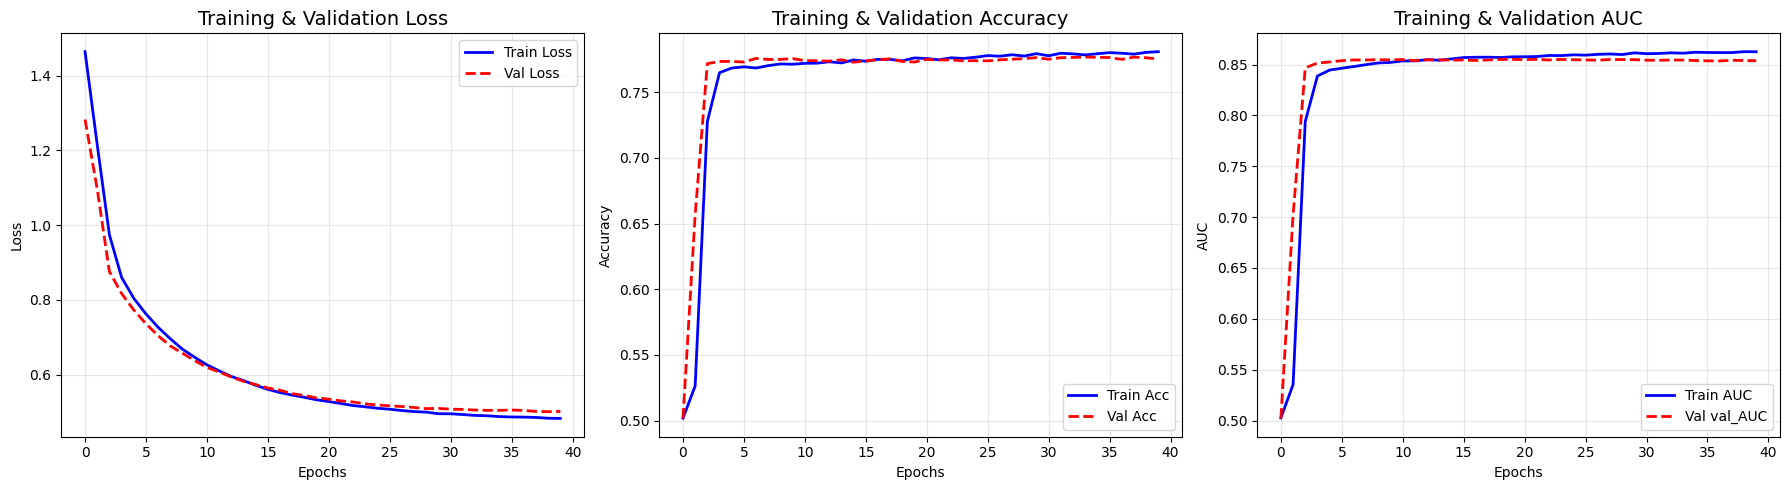

正在繪製 ROC 曲線...


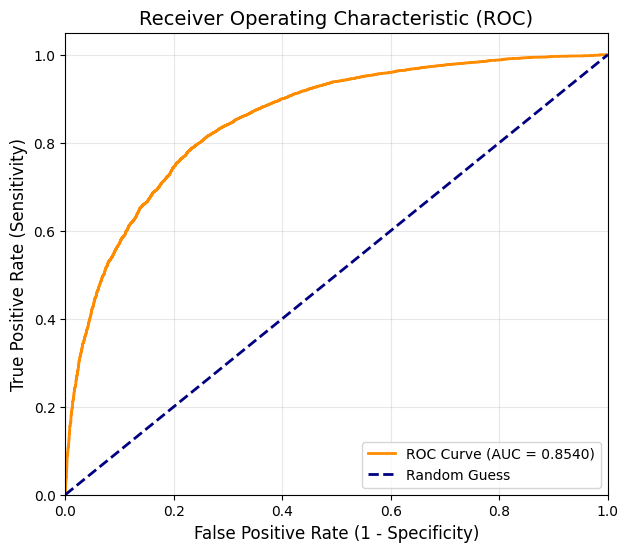

In [2]:
# =========================================================
# 7. 視覺化儀表板 (修正版 - 自動偵測 Key)
# =========================================================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_training_history(history):
    # 1. 取得所有 keys 並列印出來確認
    keys = list(history.history.keys())
    print(f"訓練紀錄包含的 Keys: {keys}")
    
    # 2. 自動搜尋 AUC key (不分大小寫)
    # 搜尋邏輯：包含 'auc' 且不含 'val' 的是 Train AUC
    auc_key = next((k for k in keys if 'auc' in k.lower() and 'val' not in k.lower()), None)
    # 搜尋邏輯：包含 'auc' 且包含 'val' 的是 Val AUC
    val_auc_key = next((k for k in keys if 'auc' in k.lower() and 'val' in k.lower()), None)

    # 設定畫布大小
    plt.figure(figsize=(18, 5))

    # --- 1. Loss Curve ---
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Training & Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- 2. Accuracy Curve ---
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Acc', color='red', linestyle='--', linewidth=2)
    plt.title('Training & Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- 3. AUC Curve (如果有找到 key 才畫) ---
    plt.subplot(1, 3, 3)
    if auc_key and val_auc_key:
        plt.plot(history.history[auc_key], label=f'Train {auc_key}', color='blue', linewidth=2)
        plt.plot(history.history[val_auc_key], label=f'Val {val_auc_key}', color='red', linestyle='--', linewidth=2)
        plt.title('Training & Validation AUC', fontsize=14)
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'AUC Metric Not Found', ha='center', va='center', fontsize=14)
        print("⚠️ 警告：無法在 history 中找到 AUC 相關標籤，已跳過 AUC 繪圖。")
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 執行繪圖 ---
print("正在繪製訓練過程圖表...")
plot_training_history(history)

print("正在繪製 ROC 曲線...")
plot_roc_curve(y_te, y_pred_prob)

正在準備 ML 模型的資料 (One-Hot Encoding)...
ML 訓練資料維度: (67520, 6957)
1/3 訓練 Logistic Regression...
2/3 訓練 Random Forest (這可能要跑一下)...
3/3 訓練 XGBoost...


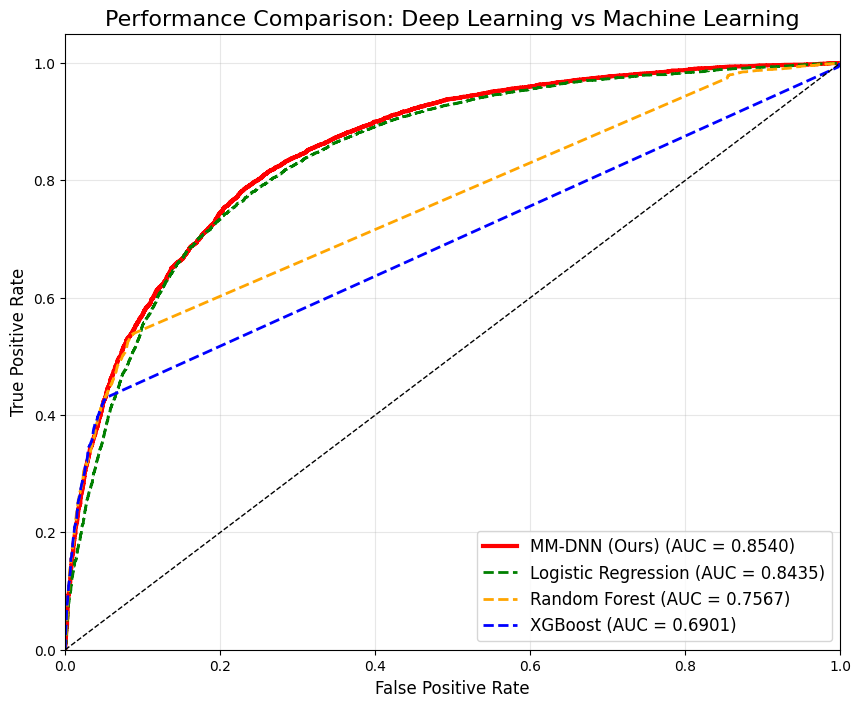


🏆 最終模型效能數值比較 (Model Performance Metrics) 🏆
              Model  Accuracy  F1 Score    AUC
      MM-DNN (Ours)    0.7768    0.7798 0.8540
Logistic Regression    0.7685    0.7673 0.8435
      Random Forest    0.6924    0.5880 0.7567
            XGBoost    0.6790    0.5553 0.6901


In [3]:
# =========================================================
# 8. 終極大亂鬥：MM-DNN vs Traditional ML Models
# 包含：ROC 曲線繪圖 + 數值比較表輸出
# =========================================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

print("正在準備 ML 模型的資料 (One-Hot Encoding)...")

# 1. 準備 ML 模型的輸入資料
# ML 模型看不懂 Embedding，所以我們要幫它把 Disease ID 轉回 One-Hot
enc = OneHotEncoder(handle_unknown='ignore')

# 訓練集
X_did_tr_ohe = enc.fit_transform(X_did_tr.reshape(-1, 1))
X_ml_train = hstack([X_drug_tr, X_did_tr_ohe]) # 結合 藥物特徵 + 疾病 One-Hot

# 測試集
X_did_te_ohe = enc.transform(X_did_te.reshape(-1, 1))
X_ml_test = hstack([X_drug_te, X_did_te_ohe])

print(f"ML 訓練資料維度: {X_ml_train.shape}")

# 2. 訓練 ML Baseline 模型
ml_models = {}

print("1/3 訓練 Logistic Regression...")
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_ml_train, y_tr)
ml_models['Logistic Regression'] = lr

print("2/3 訓練 Random Forest (這可能要跑一下)...")
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=20) # 限制深度加速
rf.fit(X_ml_train, y_tr)
ml_models['Random Forest'] = rf

print("3/3 訓練 XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, n_jobs=-1, eval_metric='logloss')
xgb_model.fit(X_ml_train, y_tr)
ml_models['XGBoost'] = xgb_model

# 3. 繪製整合 ROC 曲線
plt.figure(figsize=(10, 8))

# A. 畫 MM-DNN (我們的主角)
fpr_dnn, tpr_dnn, _ = roc_curve(y_te, y_pred_prob)
auc_dnn = roc_auc_score(y_te, y_pred_prob)
plt.plot(fpr_dnn, tpr_dnn, color='red', lw=3, label=f'MM-DNN (Ours) (AUC = {auc_dnn:.4f})')

# B. 畫 ML Models
colors = ['green', 'orange', 'blue']
for (name, model), color in zip(ml_models.items(), colors):
    # 預測機率
    y_prob_ml = model.predict_proba(X_ml_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_te, y_prob_ml)
    auc_score = roc_auc_score(y_te, y_prob_ml)
    
    plt.plot(fpr, tpr, color=color, lw=2, linestyle='--', label=f'{name} (AUC = {auc_score:.4f})')

# C. 裝飾圖表
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Performance Comparison: Deep Learning vs Machine Learning', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 4. [新增] 輸出數值比較表 (Accuracy, F1, AUC)
# =========================================================

# 準備列表存結果
metrics_data = []

# --- A. MM-DNN 指標 ---
# 使用之前找到的最佳門檻 (best_thresh)，如果沒有則預設 0.5
threshold = best_thresh if 'best_thresh' in locals() else 0.5
y_pred_dnn = (y_pred_prob > threshold).astype(int)

metrics_data.append({
    'Model': 'MM-DNN (Ours)',
    'Accuracy': accuracy_score(y_te, y_pred_dnn),
    'F1 Score': f1_score(y_te, y_pred_dnn),
    'AUC': roc_auc_score(y_te, y_pred_prob)
})

# --- B. ML Models 指標 ---
for name, model in ml_models.items():
    # 預測機率
    y_prob_ml = model.predict_proba(X_ml_test)[:, 1]
    # 預測標籤 (使用預設 0.5 門檻)
    y_pred_ml = model.predict(X_ml_test)
    
    metrics_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_te, y_pred_ml),
        'F1 Score': f1_score(y_te, y_pred_ml),
        'AUC': roc_auc_score(y_te, y_prob_ml)
    })

# 轉成 DataFrame 並印出
metrics_df = pd.DataFrame(metrics_data)

print("\n" + "="*60)
print("🏆 最終模型效能數值比較 (Model Performance Metrics) 🏆")
print("="*60)
print(metrics_df.to_string(index=False, float_format="%.4f"))
print("="*60)


正在執行 PCA 降維可視化...
PCA 保留資訊量: PC1=4.27%, PC2=3.46%


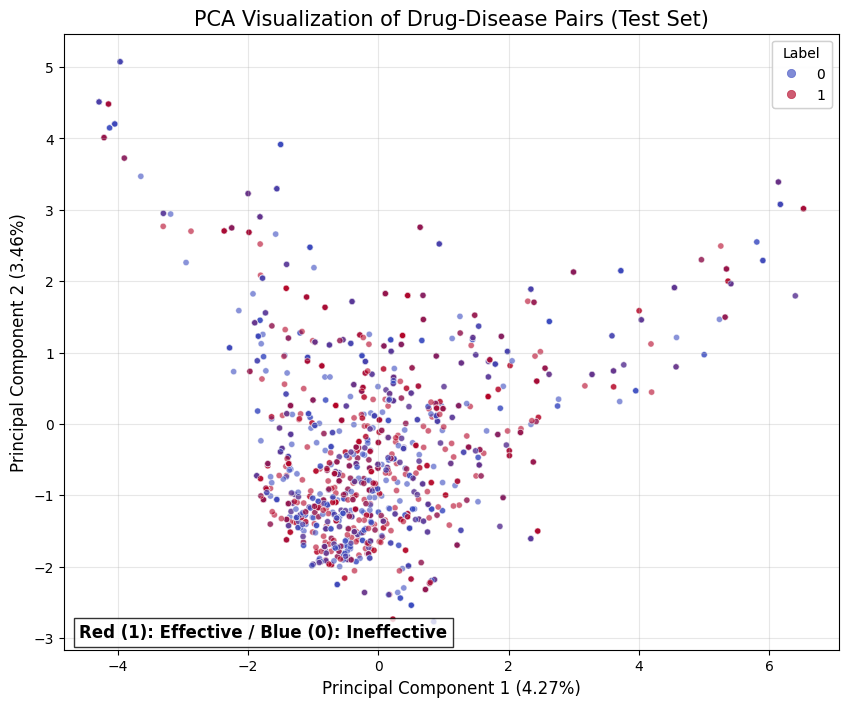

PCA 圖表繪製完成！


In [5]:
# =========================================================
# 10. [修正版] PCA 可視化：資料分佈圖
# 修正：增加 .tocsr() 轉換，解決 TypeError
# =========================================================
from sklearn.decomposition import PCA

print("\n正在執行 PCA 降維可視化...")

# 1. 格式轉換與隨機採樣
# 關鍵修正：先將稀疏矩陣轉為 CSR 格式，才能進行切片索引
X_ml_test_csr = X_ml_test.tocsr()

sample_size = 2000
if X_ml_test_csr.shape[0] > sample_size:
    # 隨機選取索引
    indices = np.random.choice(X_ml_test_csr.shape[0], sample_size, replace=False)
    # 取出這些索引的資料並轉為 Dense (PCA 需要 Dense)
    X_sample = X_ml_test_csr[indices].toarray()
    y_sample = y_te[indices]
else:
    X_sample = X_ml_test_csr.toarray()
    y_sample = y_te

# 2. 執行 PCA (降維到 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

# 計算解釋變異量
var_ratio = pca.explained_variance_ratio_
print(f"PCA 保留資訊量: PC1={var_ratio[0]:.2%}, PC2={var_ratio[1]:.2%}")

# 3. 繪圖
plt.figure(figsize=(10, 8))

# 繪製散佈圖
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], 
    c=y_sample,          
    cmap='coolwarm',     
    alpha=0.6,           
    s=20,                
    edgecolor='w',       
    linewidth=0.5
)

# 裝飾圖表
plt.title('PCA Visualization of Drug-Disease Pairs (Test Set)', fontsize=15)
plt.xlabel(f'Principal Component 1 ({var_ratio[0]:.2%})', fontsize=12)
plt.ylabel(f'Principal Component 2 ({var_ratio[1]:.2%})', fontsize=12)

# 製作圖例
legend1 = plt.legend(*scatter.legend_elements(), title="Label")
plt.gca().add_artist(legend1)

# 加入標註說明
plt.text(
    0.02, 0.02, 
    "Red (1): Effective / Blue (0): Ineffective", 
    transform=plt.gca().transAxes, 
    fontsize=12, fontweight='bold', 
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.grid(True, alpha=0.3)
plt.show()

print("PCA 圖表繪製完成！")